# Single Step ConvLSTM model

This notebook contains a Single Step ConvLSTM model for flood predictions. 
It was developed for CEGM2003 DSAIE Crossover Module during 2023/2024 academic year at Delft University of Technology, Faculty of Civil Engineering and Geosciences.

Credits to the original ConvLSTM model architecture go to [Andrea Palazzi](https://github.com/ndrplz) and [Davide Abati](https://github.com/DavideA).
The source code is provided in the ([ConvLSTM_pytorch file](https://github.com/ndrplz/ConvLSTM_pytorch)), which is based on [this model](https://github.com/rogertrullo/pytorch_convlstm/blob/master/conv_lstm.py) implemented by [Roger Trullo](https://github.com/rogertrullo).

For more information refer to the README in <code>models/ConvLSTM_model/ConvLSTM_pytorch/README.md</code>.

Group: FLOOD2 ([GitHub group repository](https://github.com/antoniomagherini99/FLOOD_group2)). 

Authors of the notebook:
- Lucas Terlinden-Ruhl 
\
(student number: 5863937, email: L.J.R.Terlinden-Ruhl@student.tudelft.nl)


- Antonio Magherini 
\
(student number: 5838215, email: A.Magherini@student.tudelft.nl)

The model implemented in this noteboook is a Single Step ConvLSTM: it combines a convolutional layer and the architecture of an LSTM model. It contains 48 layers as each layer is associated with a single predicted time step. The parameters were chosen based on an optimization process: different combinations of learning rate, hidden dimensions and so on were tested to get to this final version.

In [1]:
# move to the root directory of the git

%cd ..
%cd ..

c:\Users\anton\OneDrive\Desktop\TU Delft\Q6\Data Science and Artificial Intelligence for Engineers\FLOOD_group2\models
c:\Users\anton\OneDrive\Desktop\TU Delft\Q6\Data Science and Artificial Intelligence for Engineers\FLOOD_group2


In [2]:
# import libraries and modules

import joblib
import torch
import copy

import matplotlib.pyplot as plt

# Enable interactive widgets in Jupyter Notebook
%matplotlib widget

from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

from models.ConvLSTM_model.ConvLSTM_pytorch.convlstm import ConvLSTM
from models.ConvLSTM_model.train_eval import train_epoch_conv_lstm, evaluation_conv_lstm
from pre_processing.encode_decode_csv import decode_from_csv
from pre_processing.normalization import * 
from pre_processing.augmentation import * 
from post_processing.cool_animation import plot_animation
from post_processing.plots import *

The following cell is used to save the file path where to store the model. We suggest to use the following nomenclature for differentiate among different models:

- <code>conv_lstm</code> specifies the type of the model (ConvLSTM in this case);
- <code>32hid</code> specifies the number of hidden dimensions (32 in this case);
- <code>48lay</code> specifies the number of layers (48 in this case);
- <code>5ker</code> specifies the size of the kernel (5x5 in this case);
- <code>augmentation</code> specifies that data augmentation is applied to the original dataset

<span style="color: red;">**Please note! In order not to overwrite the original models, when uncommenting the following lines the saved files must be renamed.**</span>

In [3]:
# model save path
save_path = 'models/ConvLSTM_model/model_paths/conv_lstm_32hid_48lay_5ker_augmentation.pth'

Check if GPU is available.

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


The following lines create variables to more easily specify what we use the model for and therefore which dataset to load in the following functions.

<code>train_val</code> specifies the model is used for training and validation, <code>test1</code> specifies the model is used for testing dataset 1, etc.

In [5]:
train_val = 'train_val'
test1 = 'test1'
test2 = 'test2'
test3 = 'test3'

Load data from decoder.

In [6]:
# training and validation dataset
train_dataset = decode_from_csv(train_val)

Restored inputs Shape: torch.Size([80, 1, 4, 64, 64])
Restored targets Shape: torch.Size([80, 48, 2, 64, 64])


We apply data augmentation with six different transformations: 
- three single fixed rotations of either 90°, 180°, and 270° (to keep the same dimensions of the dataset);
- three horizontal flipping, with a specified probability of flipping <code>p_hflip=0.5</code> and the same rotations as above.

In [7]:
# apply data augmentation - horizontal flipping and rotation
transformed_dataset = augmentation(train_dataset)

The samples in the dataset before augmentation were 80
The samples in the dataset after augmentation are 560


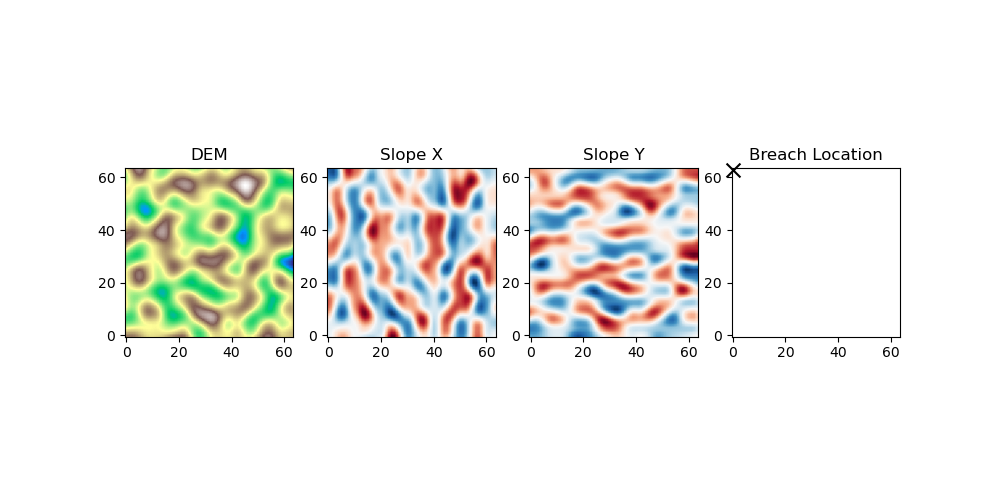

In [8]:
# From FAT application - show input dataset
fig, axs = plt.subplots(1, 4, figsize=(10, 5))

# specify which entry of the dataset to plot
numb = 157
inputs = transformed_dataset[numb][0][0]

axs[0].imshow(inputs[0].cpu(), cmap='terrain', origin='lower')
axs[0].set_title('DEM')

axs[1].imshow(inputs[1].cpu(), cmap='RdBu', origin='lower')
axs[1].set_title('Slope X')

axs[2].imshow(inputs[2].cpu(), cmap='RdBu', origin='lower')
axs[2].set_title('Slope Y')

non_zero_indices = torch.nonzero(inputs[3].cpu())
non_zero_row, non_zero_col = non_zero_indices[0][0].item(), non_zero_indices[0][1].item()
axs[3].imshow(inputs[3].cpu(), cmap='binary', origin='lower')
axs[3].set_title('Breach Location')
axs[3].scatter(non_zero_col, non_zero_row, color='k', marker='x', s=100,
                clip_on = False, clip_box = plt.gca().transData)
plt.show()

In the following cell we fix the seed for the random split of the training and validation dataset. 

This is done for keeping consistency within the [Multi Step ConvLSTM model](https://github.com/antoniomagherini99/FLOOD_group2/blob/main/models/ConvLSTM_model/test_augmentation.ipynb).

In [9]:
# fix random seed
random_gen = torch.Generator().manual_seed(42) 

# Split dataset into train and validation
train_percnt = 0.8
train_size = int(train_percnt * len(transformed_dataset))
val_size = len(transformed_dataset) - train_size
train_set, val_set = random_split(transformed_dataset, [train_size, val_size], random_gen)

In [10]:
# Normalize the inputs and outputs using training dataset
scaler_x, scaler_y = scaler(train_set)

normalized_train_dataset = normalize_dataset(train_set, scaler_x, scaler_y, train_val)
normalized_val_dataset = normalize_dataset(val_set, scaler_x, scaler_y, train_val)

In the next cell we save <code>scaler_x</code> and <code>scaler_y</code> for which the random seed was fixed and the data augmentation was applied. This is done for reusing the same scalers in the testing notebook. 

As the scalers need to be saved only the first time the notebook is run, the following lines are commented. Every time the random seed of the scaler is changed and/or the augmentation function is changed (different transformation, different amount of transformations), the scalers need to be saved again. 

<span style="color: red;">**Please note: in order not to overwrite the original scalers, when uncommenting the following lines the saved files must be renamed.**</span>

In [11]:
# ## save scalers for use in seperate notebooks on testing
# joblib.dump(scaler_x, 'models/ConvLSTM_model/scalers/scaler_x.joblib')
# joblib.dump(scaler_y, 'models/ConvLSTM_model/scalers/scaler_y.joblib');

In this Single Step ConvLSTM model, each layer is related to a single time step. Each layer therefore receives only one sequential input, compared to the Multi Step ConvLSTM which receives two.

Given a specific hidden dimension <code>hidden_dim</code>, each layer receives this as hidden dimension of the previous layer (= time step) and generates another <code>hidden_dim</code> unique to that specific layer, which eventually means that each layer doubles its <code>hidden_dim</code>. It then outputs <code>hidden_dim</code> to the next layer (= time step). Therefore, the next layer receives <code>hidden_dim</code> as hidden dimension of previous layer (= time step) and outputs <code>hidden_dim</code> for both next layer and so on.

The model has only one convolutional layer located before the gates. This layer outputs a 4*<code>hidden_dim</code> to each gate because there are 4 gates (input, forget, tanh activation and output). 

As this is a Single Step predicting model, it needs <code>num_layers=48</code> for the first two datasets (<code>num_layers=120</code> for the third). It doesn't provide the hidden state to the next time step but only to next layer, which effectively represents the next time step. It is autoregressive (there is a relation in time) but layers are different per each time step, therefore also parameters are different leading to an increase of the total amount of parameters needed.

The convolutional layer implements the spatial bias, while the LSTM cells implement sequential bias.
In terms of model architecture, adding more hidden layers is beneficial to increase the hierarchical bias of the latest time steps, although a too complex model will likely overfit more easily and without including residual connections shattered gradients can be expected to occur. 

Every ConvLSTM cell/layer creates <code>hidden_dim</code> number of outputs, therefore we need a 1x1 kernel at every output in order to reduce the number of hidden dimensions to the number of targets (in this case 2). Each layer has therefore two 1x1 kernels, one for each target. Therefore there are 96 1x1 kernels and the number of parameters is 2x96=192 weights. The alternative was an MLP (or fully connected layer), which would result in a number of parameters equal to <code>hidden_dim</code>x<code>pixels</code>x<code>pixels</code>x<code>output_dim</code>x<code>num_layers</code>, that is more than 6 million parameters in total. It is clear that such model would increase the computational cost significantly.

After the 1x1 kernel we could activate the output channels. One possible option was to use <code>ReLU</code> because we expect only positive values of the targets (water depth and discharge) so we want predictions to be positive as well. We eventually did not implement this because in the earlier stages of the training the model weights were not efficiently updated to learn the flood evolution. Without ReLU activation the model can produce negative results which increase the loss and enhance the model learning. On the other hand, this means that the model can predicet negative values which are always not expected to occur.

For predicting 48 time steps, the length of the training and validation dataset targets, the current model architecture allows to have at most 48 layers. Therefore, to generalize to a larger amount of time steps we would need to create multiple models and stack them sequentially in time. This would require more parameters and would induce the first ConvLSTM cell to predict the 1<sup>st</sup> and 49<sup>th</sup> time steps, the second cell the 2<sup>nd</sup> and 50<sup>th</sup> time steps and so on, reducing the learning.   

In [12]:
# The Model
model = ConvLSTM(input_dim = normalized_train_dataset[0][0].shape[1], 
                 output_dim = normalized_train_dataset[0][1].shape[1], 
                 hidden_dim = 32, kernel_size = (5, 5), num_layers = 48, 
                 batch_first=True, bias=True, return_all_layers = True).to(device)

In [13]:
# show the model
model

ConvLSTM(
  (conv2): Conv2d(32, 2, kernel_size=(1, 1), stride=(1, 1))
  (cell_list): ModuleList(
    (0): ConvLSTMCell(
      (conv): Conv2d(36, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (1-47): 47 x ConvLSTMCell(
      (conv): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
  )
)

In [14]:
# print the number of parameters and model size
num_parameters = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_parameters}")
model_size_MB = num_parameters * 4 / (1024 ** 2)  # Assuming float32 precision
print(f"Model size: {model_size_MB:.2f} MB")

Number of parameters: 9747010
Model size: 37.18 MB


In [ ]:
# Set training parameters
learning_rate = 0.0001
batch_size = 32
num_epochs = 3500

# Create the optimizer to train the neural network via back-propagation
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# Create the scheduler for decreasing the learning rate every specified amount of epochs with a factor = gamma
scheduler = StepLR(optimizer, step_size = 50, gamma = 0.8)

# Create the training and validation dataloaders to feed data to the model in batches
train_loader = DataLoader(normalized_train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(normalized_val_dataset, batch_size=batch_size, shuffle=False)

The model can now be trained. The loss used in this notebook is the Mean Squared Error (<code>'MSE'</code>) but Mean Absolute Error can also be used (<code>'MAE'</code>). 

To use the Mean Absolute Error it is enough to set <code>loss_f='MAE'</code>.

In [ ]:
# initialize lists
train_losses = []
val_losses = []
count = 0

# specify loss function
loss_f = 'MSE'

# train and validate the model
for epoch in range(1, num_epochs+1):
    scheduler.step()
    
    # Model training
    train_loss = train_epoch_conv_lstm(model, train_loader, optimizer, device, loss_f)

    # Model validation
    val_loss = evaluation_conv_lstm(model, val_loader, device, loss_f)

    if epoch == 1:
        best_loss = val_loss

    # save best model
    if val_loss<=best_loss:
        best_model = copy.deepcopy(model)
        best_loss = val_loss
        best_epoch = epoch
        count = 0

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    count += 1

    if epoch%10 == 0:
        print(f"Epoch: {epoch} " +
              f"\t Training loss: {train_loss: .2e} " + 
              f"\t Validation loss: {val_loss: .2e} " +
              f"\t Best validation loss: {best_loss: .2e}")
        print(f'Current learning rate: {scheduler.get_last_lr()[0]}')

In [ ]:
# save best model
model = copy.deepcopy(best_model)
torch.save(model.state_dict(), save_path)

In [ ]:
# show loss evolution with epochs
plot_losses(train_losses, val_losses, model)

In the next cell, <code>save=True</code> has to be set in order to save the animated gif otherwise it will just be displayed. 

In [ ]:
# plot animated gif showing the flood propagation in time
plot_animation(30, normalized_val_dataset, model, train_val,
               scaler_x, scaler_y, device = device, save = False, loss_f=loss_f)

In [ ]:
# plot samples, losses and recall based on increasing loss
plot_sorted(normalized_val_dataset, model, train_val, scaler_x, scaler_y, device, loss_f=loss_f)